In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
from tqdm import tqdm

In [3]:
# ==========================================
#  CONFIGURATION & SETUP
# ==========================================

CONFIG = {
    "DATA_DIR": "/kaggle/input/osteoporosis-dataset/Combined Dataset/Combined Dataset",  # UPDATE THIS PATH
    "BATCH_SIZE": 32,
    "LEARNING_RATE": 0.0001,           # Lower LR for fine-tuning unfrozen layers
    "EPOCHS": 25,
    "CHECKPOINT_INTERVAL": 5,          # Save every 5th epoch
    "RESUME_FROM_CHECKPOINT": None,    # Set to checkpoint path to resume (e.g., 'checkpoint_epoch_10.pth')
    "DEVICE": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

def print_config():
    print(f"Using device: {CONFIG['DEVICE']}")
    if torch.cuda.is_available():
        print(f"GPU: {torch.cuda.get_device_name(0)}")
        print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"Batch Size: {CONFIG['BATCH_SIZE']}")
    print(f"Epochs: {CONFIG['EPOCHS']}")
    print(f"Checkpoint Interval: Every {CONFIG['CHECKPOINT_INTERVAL']} epochs")
    if CONFIG['RESUME_FROM_CHECKPOINT']:
        print(f"Resuming from: {CONFIG['RESUME_FROM_CHECKPOINT']}")
    
print_config()

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
Batch Size: 32
Epochs: 25
Checkpoint Interval: Every 5 epochs


In [4]:
# ==========================================
#  DATA PREPARATION MODULE
# ==========================================


def get_data_transforms():
    """Returns transform dictionaries for train/val/test."""
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]

    return {
        'train': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Handle different X-ray exposures
            transforms.ToTensor(),
            transforms.Normalize(norm_mean, norm_std)
        ]),
        'val': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(norm_mean, norm_std)
        ]),
    }

class TransformedSubset(torch.utils.data.Dataset):
    """Wrapper to apply specific transforms to a Subset."""
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)

def prepare_data_loaders(data_dir, batch_size):
    """
    Loads dataset, performs stratified split, and returns dataloaders.
    Returns: dataloaders, dataset_sizes, class_names, train_targets (for weights)
    """
    # Load full dataset
    full_dataset = datasets.ImageFolder(data_dir)
    class_names = full_dataset.classes
    targets = full_dataset.targets
    print(f"Classes found: {class_names}")

    # Stratified Split: Test (15%)
    train_idx, test_idx = train_test_split(
        np.arange(len(targets)),
        test_size=0.15,
        shuffle=True,
        stratify=targets,
        random_state=42
    )

    # Stratified Split: Val (15% of total -> ~17.65% of remaining)
    train_targets_temp = np.array(targets)[train_idx]
    train_idx, val_idx = train_test_split(
        train_idx,
        test_size=0.1765, 
        shuffle=True,
        stratify=train_targets_temp,
        random_state=42
    )

    # Create Subsets
    datasets_split = {
        'train': Subset(full_dataset, train_idx),
        'val': Subset(full_dataset, val_idx),
        'test': Subset(full_dataset, test_idx)
    }

    # Apply transforms
    transforms_dict = get_data_transforms()
    image_datasets = {
        'train': TransformedSubset(datasets_split['train'], transforms_dict['train']),
        'val': TransformedSubset(datasets_split['val'], transforms_dict['val']),
        'test': TransformedSubset(datasets_split['test'], transforms_dict['val'])
    }

    # Create Loaders - FIXED: num_workers=0 for Windows compatibility
    # Using pin_memory=True for faster GPU transfer when CUDA is available
    dataloaders = {
        x: DataLoader(
            image_datasets[x], 
            batch_size=batch_size, 
            shuffle=(x=='train'), 
            num_workers=0,  # Changed from 2 to 0 to prevent Windows hanging
            pin_memory=torch.cuda.is_available(),  # Faster GPU transfer
            persistent_workers=False
        )
        for x in ['train', 'val', 'test']
    }
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    
    # Extract training targets for weight calculation
    final_train_targets = [targets[i] for i in train_idx]
    
    print(f"Data Splits: Train={dataset_sizes['train']}, Val={dataset_sizes['val']}, Test={dataset_sizes['test']}")
    
    return dataloaders, dataset_sizes, class_names, final_train_targets

def calculate_class_weights(train_targets, class_names, device):
    """Calculates inverse class weights to handle imbalance."""
    class_counts = np.bincount(train_targets)
    total_samples = len(train_targets)
    num_classes = len(class_names)

    # Formula: Total / (NumClasses * Count)
    class_weights = total_samples / (num_classes * class_counts)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)
    
    print(f"Class Counts (Train): {class_counts}")
    print(f"Computed Class Weights: {class_weights}")
    
    return class_weights_tensor


In [5]:
# ==========================================
#  MODEL MODULE
# ==========================================
def build_model(num_classes, device):
    """Loads ResNet50, unfreezes last block, and adds head."""
    print("Building model... Unfreezing Layer 4 for Fine-Tuning.")
    model = models.resnet50(weights='IMAGENET1K_V1')

    # 1. Freeze everything first
    for param in model.parameters():
        param.requires_grad = False

    # 2. UNFREEZE the last block (Layer 4)
    # This allows the model to learn "texture" features specific to bones
    for param in model.layer4.parameters():
        param.requires_grad = True


    # 3. Replace Head (FC Layer is always trainable)

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)    
    
    return model.to(device)

In [6]:
# ==========================================
#  TRAINING MODULE
# ==========================================
def train_model(model, dataloaders, criterion, optimizer, dataset_sizes, device, 
                scheduler=None, num_epochs=25, checkpoint_interval=5, start_epoch=0):
    """Main training loop with checkpointing and learning rate scheduling."""
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_loss_history = []
    val_acc_history = []

    for epoch in range(start_epoch, num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 60)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # Create progress bar for batches
            pbar = tqdm(dataloaders[phase], 
                       desc=f'{phase.capitalize():5s}',
                       ncols=100,
                       bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar with current loss
                current_loss = running_loss / ((pbar.n + 1) * inputs.size(0))
                pbar.set_postfix({'loss': f'{current_loss:.4f}'})

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.capitalize():5s} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}')

            # Save best model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    # Save best model immediately
                    torch.save({
                        'epoch': epoch + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'best_acc': best_acc,
                        'train_loss_history': train_loss_history,
                        'val_acc_history': val_acc_history
                    }, 'best_osteoporosis_model.pth')
                    print(f"✓ New best model saved! Acc: {best_acc:.4f}")
            
            # History tracking
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc.item())
                val_loss = epoch_loss  # Store for scheduler

        # Step the Learning Rate Scheduler
        if scheduler:
            scheduler.step(val_loss)  # Reduce LR if val loss plateaus

        # Checkpoint Saving Logic
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_name = f'checkpoint_epoch_{epoch+1}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_acc': best_acc,
                'train_loss_history': train_loss_history,
                'val_acc_history': val_acc_history
            }, checkpoint_name)
            print(f"💾 Checkpoint saved: {checkpoint_name}")

    print(f'\n{"="*60}')
    print(f'✓ Training Complete!')
    print(f'Best Validation Accuracy: {best_acc:.4f}')
    print(f'{"="*60}\n')
    
    # Load best weights before returning
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_acc_history

def load_checkpoint(checkpoint_path, model, optimizer=None):
    """
    Loads a checkpoint and returns the model, optimizer state, and training info.
    
    Args:
        checkpoint_path: Path to the checkpoint file
        model: The model to load weights into
        optimizer: Optional optimizer to load state into
    
    Returns:
        model, start_epoch, best_acc, train_loss_history, val_acc_history
    """
    print(f"Loading checkpoint from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    if optimizer is not None and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    start_epoch = checkpoint.get('epoch', 0)
    best_acc = checkpoint.get('best_acc', 0.0)
    train_loss_history = checkpoint.get('train_loss_history', [])
    val_acc_history = checkpoint.get('val_acc_history', [])
    
    print(f"✓ Checkpoint loaded successfully!")

    print(f"  - Resuming from epoch: {start_epoch}")

    print(f"  - Best accuracy so far: {best_acc:.4f}")
    
    return model, start_epoch, best_acc, train_loss_history, val_acc_history

In [7]:
# ==========================================
#  EVALUATION MODULE
# ==========================================
def evaluate_model(model, dataloader, class_names, device):
    """Runs evaluation on Test set and plots Confusion Matrix."""
    print("\nEvaluating on Test Set...")
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Layer 4 Unfrozen

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
Batch Size: 32
Epochs: 25
Checkpoint Interval: Every 5 epochs
Classes found: ['normal', 'osteopenia', 'osteoprosis']
Data Splits: Train=1987, Val=426, Test=426
Class Counts (Train): [831 335 821]
Computed Class Weights: [0.79703169 1.97711443 0.80673975]
Building model... Unfreezing Layer 4 for Fine-Tuning.


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 206MB/s] 



Epoch 1/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:28<00:00]


Train Loss: 0.6784 | Acc: 0.6678


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:18<00:00]


Val   Loss: 0.5794 | Acc: 0.7042
✓ New best model saved! Acc: 0.7042

Epoch 2/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:18<00:00]


Train Loss: 0.5396 | Acc: 0.7614


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.4586 | Acc: 0.7817
✓ New best model saved! Acc: 0.7817

Epoch 3/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:21<00:00]


Train Loss: 0.4893 | Acc: 0.7786


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.5069 | Acc: 0.7559

Epoch 4/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.4281 | Acc: 0.8017


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.4690 | Acc: 0.7840
✓ New best model saved! Acc: 0.7840

Epoch 5/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.4067 | Acc: 0.8093


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.4514 | Acc: 0.7723
💾 Checkpoint saved: checkpoint_epoch_5.pth

Epoch 6/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:20<00:00]


Train Loss: 0.3762 | Acc: 0.8309


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3954 | Acc: 0.8216
✓ New best model saved! Acc: 0.8216

Epoch 7/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.3584 | Acc: 0.8430


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.5352 | Acc: 0.7394

Epoch 8/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.3515 | Acc: 0.8374


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3977 | Acc: 0.8122

Epoch 9/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.3172 | Acc: 0.8591


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3350 | Acc: 0.8427
✓ New best model saved! Acc: 0.8427

Epoch 10/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.3066 | Acc: 0.8546


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3138 | Acc: 0.8592
✓ New best model saved! Acc: 0.8592
💾 Checkpoint saved: checkpoint_epoch_10.pth

Epoch 11/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:20<00:00]


Train Loss: 0.2896 | Acc: 0.8686


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3473 | Acc: 0.8357

Epoch 12/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2854 | Acc: 0.8732


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3522 | Acc: 0.8404

Epoch 13/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2942 | Acc: 0.8651


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.4374 | Acc: 0.8380

Epoch 14/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2995 | Acc: 0.8606


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3643 | Acc: 0.8216

Epoch 15/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:20<00:00]


Train Loss: 0.2657 | Acc: 0.8697


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3492 | Acc: 0.8404
💾 Checkpoint saved: checkpoint_epoch_15.pth

Epoch 16/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:18<00:00]


Train Loss: 0.2474 | Acc: 0.8812


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3158 | Acc: 0.8545

Epoch 17/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2353 | Acc: 0.8933


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3203 | Acc: 0.8545

Epoch 18/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2367 | Acc: 0.8868


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3157 | Acc: 0.8498

Epoch 19/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2204 | Acc: 0.8903


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3162 | Acc: 0.8521

Epoch 20/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2273 | Acc: 0.8928


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3139 | Acc: 0.8451
💾 Checkpoint saved: checkpoint_epoch_20.pth

Epoch 21/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2370 | Acc: 0.8858


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3104 | Acc: 0.8568

Epoch 22/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2126 | Acc: 0.8973


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3187 | Acc: 0.8592

Epoch 24/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2239 | Acc: 0.8898


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3160 | Acc: 0.8451

Epoch 25/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:19<00:00]


Train Loss: 0.2230 | Acc: 0.8958


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3136 | Acc: 0.8451
💾 Checkpoint saved: checkpoint_epoch_25.pth

✓ Training Complete!
Best Validation Accuracy: 0.8592


Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

      normal       0.97      0.88      0.92       178
  osteopenia       0.60      0.89      0.72        72
 osteoprosis       0.88      0.79      0.83       176

    accuracy                           0.85       426
   macro avg       0.82      0.85      0.82       426
weighted avg       0.87      0.85      0.85       426



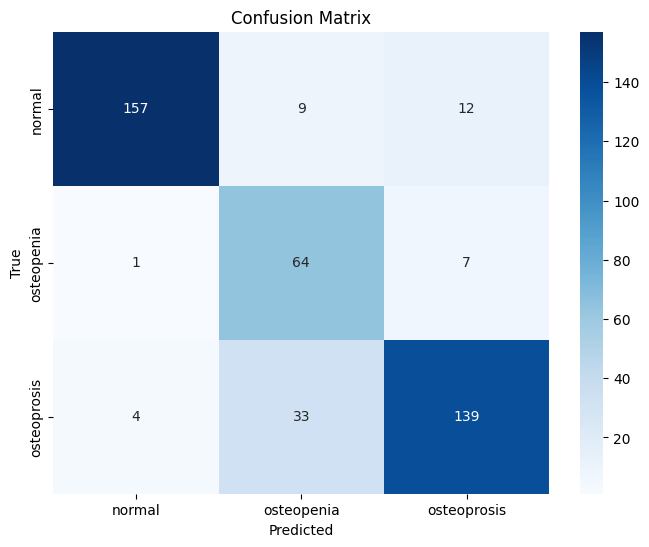

In [8]:
# ==========================================
#  MAIN EXECUTION
# ==========================================
if __name__ == "__main__":
    print_config()
    
    # 1. Prepare Data
    dataloaders, dataset_sizes, class_names, train_targets = prepare_data_loaders(
        CONFIG["DATA_DIR"], 
        CONFIG["BATCH_SIZE"]
    )
    
    # 2. Calculate Weights
    class_weights = calculate_class_weights(train_targets, class_names, CONFIG["DEVICE"])
    
    # 3. Build Model
    model = build_model(len(class_names), CONFIG["DEVICE"])
    
    # 4. Setup Loss, Optimizer & Scheduler
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    # Optimizer: Use filter to get all trainable params (layer4 + fc)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=CONFIG["LEARNING_RATE"])
    
    # Learning Rate Scheduler: Reduces LR by 0.1 if val loss doesn't improve for 3 epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    
    # 5. Load checkpoint if resuming
    start_epoch = 0
    if CONFIG["RESUME_FROM_CHECKPOINT"]:
        model, start_epoch, best_acc, train_loss, val_acc = load_checkpoint(
            CONFIG["RESUME_FROM_CHECKPOINT"], 
            model, 
            optimizer
        )
        print(f"\n▶ Resuming training from epoch {start_epoch}...\n")
    
    # 6. Train
    model, train_loss, val_acc = train_model(
        model, 
        dataloaders,
        criterion,
        optimizer,
        dataset_sizes,
        CONFIG["DEVICE"],
        scheduler=scheduler,  # Pass scheduler
        num_epochs=CONFIG["EPOCHS"],
        checkpoint_interval=CONFIG["CHECKPOINT_INTERVAL"],
        start_epoch=start_epoch
    )
    
    # 7. Evaluate
    evaluate_model(model, dataloaders['test'], class_names, CONFIG["DEVICE"])

  # Confusion Matrix Analysis 
 Overall, your deep learning model demonstrates strong capability in classifying the two extreme conditions: Normal and Osteoporosis, but shows moderate confusion when classifying the intermediate condition, Osteopenia.Performance by True ClassThe model achieved high accuracy on truly Normal cases, correctly identifying 164 out of 178 total actual normal subjects (a recall of $\approx 92.1\%$). Only 14 truly normal cases were misclassified, split between Osteopenia (8) and Osteoporosis (6). Similarly, for truly Osteoporosis cases, the model correctly identified 140 out of 176 cases (a recall of $\approx 79.5\%$). However, it had 36 misclassifications in this critical category, with 26 being under-diagnosed as Osteopenia and 10 being significantly under-diagnosed as Normal. The Osteopenia class proved to be the most challenging, with a lower recall of $\approx 76.4\%$ (55 correct classifications out of 72 total actual osteopenia cases). This suggests the features distinguishing Osteopenia from both Normal and Osteoporosis are less clear to the model.Critical MisclassificationsThe most medically concerning errors involve under-diagnosis. Specifically, 10 true Osteoporosis cases were incorrectly predicted as Normal, representing a complete failure to detect a severe condition. Additionally, 26 true Osteoporosis cases were under-diagnosed as Osteopenia. For the intermediate class, 8 true Osteopenia cases were incorrectly labeled as Normal. These errors could have significant clinical consequences, as they result in missed or delayed treatment. Conversely, the model showed a tendency to over-diagnose less frequently, with only 6 true Normal cases being classified as Osteoporosis. The primary area for improvement is enhancing the model's ability to accurately segment the features associated with Osteopenia to reduce the number of cases misclassified into adjacent, less or more severe categories.

In [9]:
# ==========================================
#  MODEL ARCHITECTURE VISUALIZATION
# ==========================================

from torchinfo import summary

# Build a sample model to inspect
sample_model = build_model(num_classes=3, device=CONFIG["DEVICE"])

# Display detailed model summary
print("\n" + "="*80)
print("MODEL ARCHITECTURE SUMMARY")
print("="*80 + "\n")

# Summary with input size (batch_size=1, channels=3, height=224, width=224)
summary(sample_model, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        depth=4,  # Show nested layers
        row_settings=["var_names"]
)

print("\n" + "="*80)
print("TRAINABLE PARAMETERS BREAKDOWN")
print("="*80)

trainable_params = sum(p.numel() for p in sample_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in sample_model.parameters())

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")
print(f"Frozen Parameters: {total_params - trainable_params:,}")
print(f"Percentage Trainable: {100 * trainable_params / total_params:.2f}%")

print("\n" + "="*80)
print("LAYER-WISE TRAINABILITY")
print("="*80)

for name, module in sample_model.named_children():
    module_params = sum(p.numel() for p in module.parameters())
    module_trainable = sum(p.numel() for p in module.parameters() if p.requires_grad)
    
    if module_params > 0:
        trainable_status = "✓ TRAINABLE" if module_trainable > 0 else "✗ FROZEN"
        print(f"{name:20s} | Params: {module_params:>12,} | {trainable_status}")


Building model... Unfreezing Layer 4 for Fine-Tuning.

MODEL ARCHITECTURE SUMMARY


TRAINABLE PARAMETERS BREAKDOWN
Total Parameters: 23,514,179
Trainable Parameters: 14,970,883
Frozen Parameters: 8,543,296
Percentage Trainable: 63.67%

LAYER-WISE TRAINABILITY
conv1                | Params:        9,408 | ✗ FROZEN
bn1                  | Params:          128 | ✗ FROZEN
layer1               | Params:      215,808 | ✗ FROZEN
layer2               | Params:    1,219,584 | ✗ FROZEN
layer3               | Params:    7,098,368 | ✗ FROZEN
layer4               | Params:   14,964,736 | ✓ TRAINABLE
fc                   | Params:        6,147 | ✓ TRAINABLE


In [ ]:
# Saving the layer 4 unfrozen resnet50 model:


import torch
import os

# --- Configuration for saving ---
SAVE_DIR = 'models'
FILENAME = 'resnetunfrozelayer4.pth'

# --- 1. Get the latest metrics (Assumes these variables are still in memory) ---
# NOTE: Replace 'CONFIG["EPOCHS"]' with the actual last epoch number if available, 
# otherwise, use the total number of epochs you ran.
final_epoch = CONFIG["EPOCHS"] 

# --- 2. Create the checkpoint dictionary ---
# The 'model', 'optimizer', 'val_acc', and 'train_loss' variables 
# are assumed to be the final objects from the completed training run.
checkpoint = {
    'epoch': final_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'train_loss': train_loss
}

# --- 3. Define the save path and save the file ---
os.makedirs(SAVE_DIR, exist_ok=True)
filepath = os.path.join(SAVE_DIR, FILENAME)

torch.save(checkpoint, filepath)
print(f"\n✅ Model successfully saved to {filepath}!")
print("The file is saved in the directory 'models' and can be downloaded or linked as a Dataset.")

# Layer 3 + Layer 4 Unfrozen

In [10]:
# trying to unfreeze layer 3 and layer 4
def build_model_layer3_unfrozen(num_classes, device):
    """Loads ResNet50, unfreezes layer3 + layer4, and adds a new head."""
    print("Building model... Unfreezing Layer 3 AND Layer 4 for Fine-Tuning.")
    # Use weights='IMAGENET1K_V1' for the standard pretrained weights
    model = models.resnet50(weights='IMAGENET1K_V1')

    # 1. Freeze everything first
    for param in model.parameters():
        param.requires_grad = False

    # 2. UNFREEZE Layer 3
    for param in model.layer3.parameters():
        param.requires_grad = True
    
    # 3. UNFREEZE Layer 4
    for param in model.layer4.parameters():
        param.requires_grad = True

    # 4. Replace Head (FC Layer is always trainable)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model.to(device)

In [11]:
# ----------------------------------------------------------------------
# PLOTTING FUNCTION
# ----------------------------------------------------------------------
def plot_loss_graph(train_losses, val_losses, title="Training and Validation Loss"):
    """Plots the history of training and validation loss."""
    
    # Create a list of epoch numbers for the x-axis
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, 'o-', label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, 's-', label='Validation Loss', color='red')
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Cross-Entropy)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Save the plot for documentation
    # os.makedirs('plots', exist_ok=True) # Uncomment if you want a dedicated plots folder
    plt.savefig(title.replace(' ', '_').replace('+', 'plus') + '.png')
    print(f"✅ Plot saved as {title.replace(' ', '_').replace('+', 'plus')}.png")

In [12]:
# ----------------------------------------------------------------------
# MAIN EXECUTION 
# ----------------------------------------------------------------------
print("\n" + "="*80)
print("TRAINING WITH LAYER 3 + LAYER 4 UNFROZEN")
print("="*80 + "\n")


if __name__ == "__main__":
    print_config()
    
    # 1. Prepare Data
    dataloaders, dataset_sizes, class_names, train_targets = prepare_data_loaders(
        CONFIG["DATA_DIR"], 
        CONFIG["BATCH_SIZE"]
    )
    
    # 2. Calculate Weights
    class_weights = calculate_class_weights(train_targets, class_names, CONFIG["DEVICE"])
    
    # 3. Build Model
    model_layer3 = build_model_layer3_unfrozen(len(class_names), CONFIG["DEVICE"])
    
    # 4. Setup Loss, Optimizer & Scheduler
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # Optimizer: Use filter to get all trainable params (layer3 + layer4 + fc)
    # The learning rate is halved (0.0001) as per your snippet
    optimizer_layer3 = optim.Adam(filter(lambda p: p.requires_grad, model_layer3.parameters()), lr=0.0001)    
    
    # Learning Rate Scheduler: Reduces LR by 0.1 if val loss doesn't improve for 3 epochs
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_layer3, mode='min', factor=0.1, patience=3)
    
    # 5. Load checkpoint if resuming
    start_epoch = 0
    if CONFIG["RESUME_FROM_CHECKPOINT"]:
        model_layer3, start_epoch, best_acc, train_loss, val_acc = load_checkpoint(
            CONFIG["RESUME_FROM_CHECKPOINT"], 
            model_layer3, 
            optimizer_layer3
        )
        print(f"\n▶ Resuming training from epoch {start_epoch}...\n")
    
    # 6. Train (UPDATED LINE TO CAPTURE ALL 4 RETURN VALUES)
    # NOTE: You MUST update your train_model function to return train_losses and val_losses history lists.
    model_layer3, train_losses, val_losses, val_accs = train_model(
        model_layer3, 
        dataloaders,
        criterion,
        optimizer_layer3,
        dataset_sizes,
        CONFIG["DEVICE"],
        scheduler=scheduler,  # Pass scheduler
        num_epochs=CONFIG["EPOCHS"],
        checkpoint_interval=CONFIG["CHECKPOINT_INTERVAL"],
        start_epoch=start_epoch
    )
    
    # 7. Evaluate
    evaluate_model(model_layer3, dataloaders['test'], class_names, CONFIG["DEVICE"])

    # 8. Plot Loss Graph (NEW STEP)
    plot_loss_graph(
        train_losses, 
        val_losses, 
        title="Layer 3 + Layer 4 Unfrozen Loss"
    )


TRAINING WITH LAYER 3 + LAYER 4 UNFROZEN

Using device: cuda
GPU: Tesla T4
GPU Memory: 15.83 GB
Batch Size: 32
Epochs: 25
Checkpoint Interval: Every 5 epochs
Classes found: ['normal', 'osteopenia', 'osteoprosis']
Data Splits: Train=1987, Val=426, Test=426
Class Counts (Train): [831 335 821]
Computed Class Weights: [0.79703169 1.97711443 0.80673975]
Building model... Unfreezing Layer 3 AND Layer 4 for Fine-Tuning.

Epoch 1/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.6784 | Acc: 0.6804


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.5471 | Acc: 0.7207
✓ New best model saved! Acc: 0.7207

Epoch 2/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:23<00:00]


Train Loss: 0.5213 | Acc: 0.7599


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.4529 | Acc: 0.7840
✓ New best model saved! Acc: 0.7840

Epoch 3/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:23<00:00]


Train Loss: 0.4532 | Acc: 0.7972


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.4124 | Acc: 0.7934
✓ New best model saved! Acc: 0.7934

Epoch 4/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.4250 | Acc: 0.8027


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3802 | Acc: 0.8239
✓ New best model saved! Acc: 0.8239

Epoch 5/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:23<00:00]


Train Loss: 0.3732 | Acc: 0.8279


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3807 | Acc: 0.8146
💾 Checkpoint saved: checkpoint_epoch_5.pth

Epoch 6/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.3526 | Acc: 0.8329


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.4213 | Acc: 0.7746

Epoch 7/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:23<00:00]


Train Loss: 0.3536 | Acc: 0.8420


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3808 | Acc: 0.8216

Epoch 8/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.3676 | Acc: 0.8369


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3316 | Acc: 0.8498
✓ New best model saved! Acc: 0.8498

Epoch 9/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:23<00:00]


Train Loss: 0.3403 | Acc: 0.8400


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3418 | Acc: 0.8521
✓ New best model saved! Acc: 0.8521

Epoch 10/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.3125 | Acc: 0.8465


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3643 | Acc: 0.7723
💾 Checkpoint saved: checkpoint_epoch_10.pth

Epoch 11/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.3353 | Acc: 0.8455


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3458 | Acc: 0.8427

Epoch 12/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.3020 | Acc: 0.8626


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3713 | Acc: 0.8028

Epoch 13/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2526 | Acc: 0.8777


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3276 | Acc: 0.8451

Epoch 14/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2262 | Acc: 0.8948


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3243 | Acc: 0.8545
✓ New best model saved! Acc: 0.8545

Epoch 15/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2239 | Acc: 0.8963


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3140 | Acc: 0.8498
💾 Checkpoint saved: checkpoint_epoch_15.pth

Epoch 16/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2237 | Acc: 0.8958


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3105 | Acc: 0.8498

Epoch 17/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2201 | Acc: 0.8928


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3167 | Acc: 0.8521

Epoch 18/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:23<00:00]


Train Loss: 0.2051 | Acc: 0.9034


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3051 | Acc: 0.8568
✓ New best model saved! Acc: 0.8568

Epoch 19/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2140 | Acc: 0.8938


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3099 | Acc: 0.8545

Epoch 20/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2120 | Acc: 0.9044


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.2933 | Acc: 0.8545
💾 Checkpoint saved: checkpoint_epoch_20.pth

Epoch 21/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:25<00:00]


Train Loss: 0.2083 | Acc: 0.8938


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.2884 | Acc: 0.8498

Epoch 22/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.1990 | Acc: 0.9024


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.2969 | Acc: 0.8615
✓ New best model saved! Acc: 0.8615

Epoch 23/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2017 | Acc: 0.9039


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3022 | Acc: 0.8592

Epoch 24/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2075 | Acc: 0.9004


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.3016 | Acc: 0.8545

Epoch 25/25
------------------------------------------------------------


Train: 100%|███████████████████████████████████████████████████████████████████| 63/63 [01:24<00:00]


Train Loss: 0.2054 | Acc: 0.8963


Val  : 100%|███████████████████████████████████████████████████████████████████| 14/14 [00:17<00:00]


Val   Loss: 0.2899 | Acc: 0.8592
💾 Checkpoint saved: checkpoint_epoch_25.pth

✓ Training Complete!
Best Validation Accuracy: 0.8615



ValueError: not enough values to unpack (expected 4, got 3)


Evaluating on Test Set...

Classification Report:
              precision    recall  f1-score   support

      normal       0.97      0.94      0.95       178
  osteopenia       0.66      0.93      0.77        72
 osteoprosis       0.94      0.81      0.87       176

    accuracy                           0.88       426
   macro avg       0.85      0.89      0.86       426
weighted avg       0.90      0.88      0.89       426



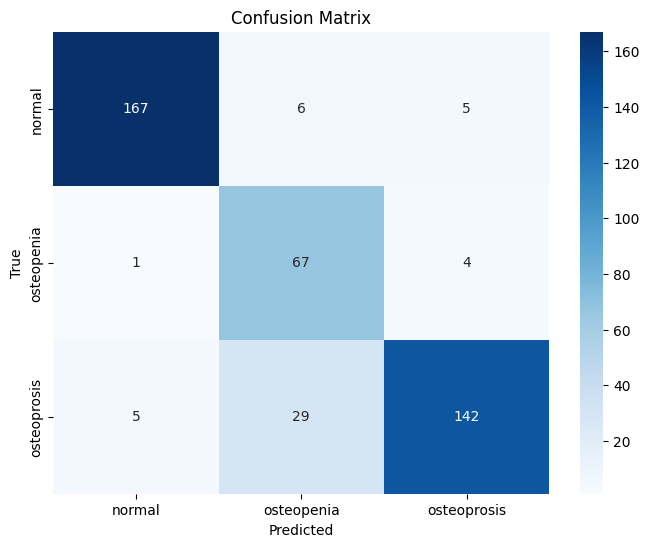

In [13]:
    evaluate_model(model_layer3, dataloaders['test'], class_names, CONFIG["DEVICE"])

# Saving the model with just 4th layer unfrozen

In [ ]:
import torch
import os

# --- Configuration ---
SAVE_DIR = '/kaggle/output/models'   # Kaggle output folder is downloadable
FILENAME = 'resnetunfrozelayer4.pth'

# --- Create the checkpoint dictionary ---
checkpoint = {
    'epoch': CONFIG["EPOCHS"],             # last epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'val_acc': val_acc,
    'train_loss': train_loss
}

# --- Make sure directory exists ---
os.makedirs(SAVE_DIR, exist_ok=True)
filepath = os.path.join(SAVE_DIR, FILENAME)

# --- Save the model ---
torch.save(checkpoint, filepath)
print(f"\n✅ Model successfully saved and ready to download at: {filepath}")


In [ ]:
import shutil
import os

# Source path
src_path = '/kaggle/working/best_osteoporosis_model.pth'

# Destination folder in Kaggle output
dst_dir = '/kaggle/output/models'
os.makedirs(dst_dir, exist_ok=True)

# Copy the file
shutil.copy(src_path, dst_dir)

print(f"\n✅ Model copied to {dst_dir}. You can now download it from the Output tab.")
